### Train a model to predict water level in a lake

In [47]:
import argparse
import pandas as pd
import hopsworks
import os

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score


parser = argparse.ArgumentParser()
parser.add_argument("--latitude", type=float, default=59.3284)
parser.add_argument("--longitude", type=float, default=18.0664)
parser.add_argument("--sensor-id", type=int, default=20389)
parser.add_argument("--sensor-name", type=str, default="malaren_w")
parser.add_argument("--water-level-fg-version", type=int, default=4)
parser.add_argument("--weather-fg-version", type=int, default=4)
parser.add_argument("--fv-version", type=int, default=2)
parser.add_argument("--test-ratio", type=float, default=0.2)

args, _ = parser.parse_known_args()

latitude = args.latitude
longitude = args.longitude
sensor_id = args.sensor_id
sensor_name = args.sensor_name
water_level_fg_version = args.water_level_fg_version
weather_fg_version = args.weather_fg_version
fv_version = args.fv_version
test_ratio = args.test_ratio


### Step 1: Login to hopsworks

Environment variable `HOPSWORKS_API_KEY` should be set

In [48]:
project = hopsworks.login(
    host="eu-west.cloud.hopsworks.ai",
    port=443,
    project="ml_project",
    api_key_value=""
)
fs = project.get_feature_store()

2026-01-11 15:16:38,271 INFO: Closing external client and cleaning up certificates.
2026-01-11 15:16:38,273 INFO: Connection closed.
2026-01-11 15:16:38,275 INFO: Initializing external client
2026-01-11 15:16:38,275 INFO: Base URL: https://eu-west.cloud.hopsworks.ai:443
2026-01-11 15:16:39,364 INFO: Python Engine initialized.

Logged in to project, explore it here https://eu-west.cloud.hopsworks.ai:443/p/2184


### Step 2: Retrieve feature groups and create a feature view

In [49]:
water_level_fg = fs.get_feature_group(
    name=f"water_level_lagged_{sensor_name}_{sensor_id}",
    version=water_level_fg_version,
)

weather_fg = fs.get_feature_group(
    name=f"weather_features_{sensor_name}_{sensor_id}",
    version=weather_fg_version,
)

In [50]:
from utils import get_water_level_features, get_weather_features

water_level_features = get_water_level_features()
weather_features = get_weather_features()

query = (
    water_level_fg
    .select(["date"] + water_level_features)
    .join(
        weather_fg.select(weather_features),
        on=["sensor_id", "date"]
    )
)

In [51]:
@hopsworks.udf(
    return_type=[int] * 12,   # month_1 ... month_12
    mode="pandas"
)
def add_month_one_hot(date: pd.Series) -> pd.DataFrame:
    """
    One-hot encode month from event-time column.
    """
    # Extract month (1–12)
    month = pd.to_datetime(date).dt.month

    # One-hot encode
    dummies = pd.get_dummies(month, prefix="month")

    # Ensure ALL 12 months exist (critical!)
    for m in range(1, 13):
        col = f"month_{m}"
        if col not in dummies:
            dummies[col] = 0

    # Stable column order
    dummies = dummies[[f"month_{m}" for m in range(1, 13)]]

    return dummies.astype("int32")

2026-01-11 15:16:50,810 WARNING: UserWarning: Cannot extract imported dependencies for the UDF from the module in which it is defined. Please make sure to import all dependencies for the UDF inside the function.



In [52]:
fv = fs.get_or_create_feature_view(
    name=f"water_level_training_view_{sensor_name}_{sensor_id}",
    version=fv_version,
    query=query,
    description=(
        "Training feature view for water level prediction. "
        "Combines lagged water level features, weather features, "
        "and on-demand month one-hot encoding."
    ),
    labels=["water_level_cm"],   # prediction target
    transformation_functions=[add_month_one_hot],
)

In [53]:
full_df = query.read()
full_df = full_df.sort_values("date")

n = len(full_df)
print(n)

split_idx = int(n * (1 - test_ratio))
split_date = full_df.iloc[split_idx]["date"]

print(f"Train fraction: {test_ratio}")
print(f"Suggested test_start date: {split_date}")

test_start = split_date
print(test_start)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (4.93s) from Hopsworks, using Hopsworks Feature Query Service.   Reading data from Hopsworks, using Hopsworks Feature Query Service...   Reading data from Hopsworks, using Hopsworks Feature Query Service.   
2186
Train fraction: 0.2
Suggested test_start date: 2024-10-28 00:00:00
2024-10-28 00:00:00


In [54]:
X_train, X_test, y_train, y_test = fv.train_test_split(
    test_start=test_start
)
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.57s) from Hopsworks, using Hopsworks Feature Query Service.   
2026-01-11 15:17:20,986 INFO: Computing insert statistics
2026-01-11 15:17:21,031 INFO: Computing insert statistics
2026-01-11 15:17:22,664 WARNING: VersionWarning: Incremented version to `11`.

X_train: (1748, 53)
X_test: (438, 53)
y_train: (1748, 1)
y_test: (438, 1)


In [55]:
# --- CLEANING ---
# Drop rows where either X or y has NaNs (keep alignment)
train_mask = X_train.notna().all(axis=1) & y_train.notna().all(axis=1)
test_mask = X_test.notna().all(axis=1) & y_test.notna().all(axis=1)

X_train = X_train.loc[train_mask].reset_index(drop=True)
y_train = y_train.loc[train_mask].reset_index(drop=True)

X_test = X_test.loc[test_mask].reset_index(drop=True)
y_test = y_test.loc[test_mask].reset_index(drop=True)

print("\nAfter cleaning:")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)


After cleaning:
X_train: (1703, 53)
X_test: (436, 53)
y_train: (1703, 1)
y_test: (436, 1)


In [56]:
assert not X_train.isna().any().any()
assert not y_train.isna().any().any()
assert not X_test.isna().any().any()
assert not y_test.isna().any().any()

In [57]:
X_features = X_train.drop(columns=['date'])
X_test_features = X_test.drop(columns=['date'])

In [58]:
# Creating an instance of the XGBoost Regressor
xgb_regressor = XGBRegressor(
    n_estimators=500,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=3,
    reg_lambda=1.0,
    reg_alpha=0.0,
    objective='reg:squarederror',
    random_state=42
)

# Fitting the XGBoost Regressor to the training data
xgb_regressor.fit(X_features, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [59]:
# Predicting target values on the test set
y_pred = xgb_regressor.predict(X_test_features)

# Calculating Mean Squared Error (MSE) using sklearn
mse = mean_squared_error(y_test.iloc[:,0], y_pred)
print("MSE:", mse)

# Calculating R squared using sklearn
r2 = r2_score(y_test.iloc[:,0], y_pred)
print("R squared:", r2)

2026-01-11 15:17:39,189 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

2026-01-11 15:17:39,192 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

MSE: 0.7329222268793132
2026-01-11 15:17:39,198 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

2026-01-11 15:17:39,199 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

R squared: 0.9731338940484184


In [60]:
df = y_test
df['predicted_water_level_cm'] = y_pred

In [61]:
df['date'] = X_test['date']
df = df.sort_values(by=['date'])
df.head(10)

,water_level_cm,predicted_water_level_cm,date
100,84.0,83.107811,2024-10-28
77,83.0,84.133301,2024-10-29
49,83.0,82.944351,2024-10-30
50,82.0,83.200790,2024-10-31
320,82.0,81.791870,2024-11-01
126,81.0,82.764786,2024-11-02
247,81.0,81.264946,2024-11-03
101,81.0,81.654144,2024-11-04
164,81.0,81.301743,2024-11-05
373,81.0,81.211914,2024-11-06


In [62]:
# Creating a directory for the model artifacts if it doesn't exist
artifacts_dir = "../artifacts"
if not os.path.exists(artifacts_dir):
    os.mkdir(artifacts_dir)
images_dir = artifacts_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

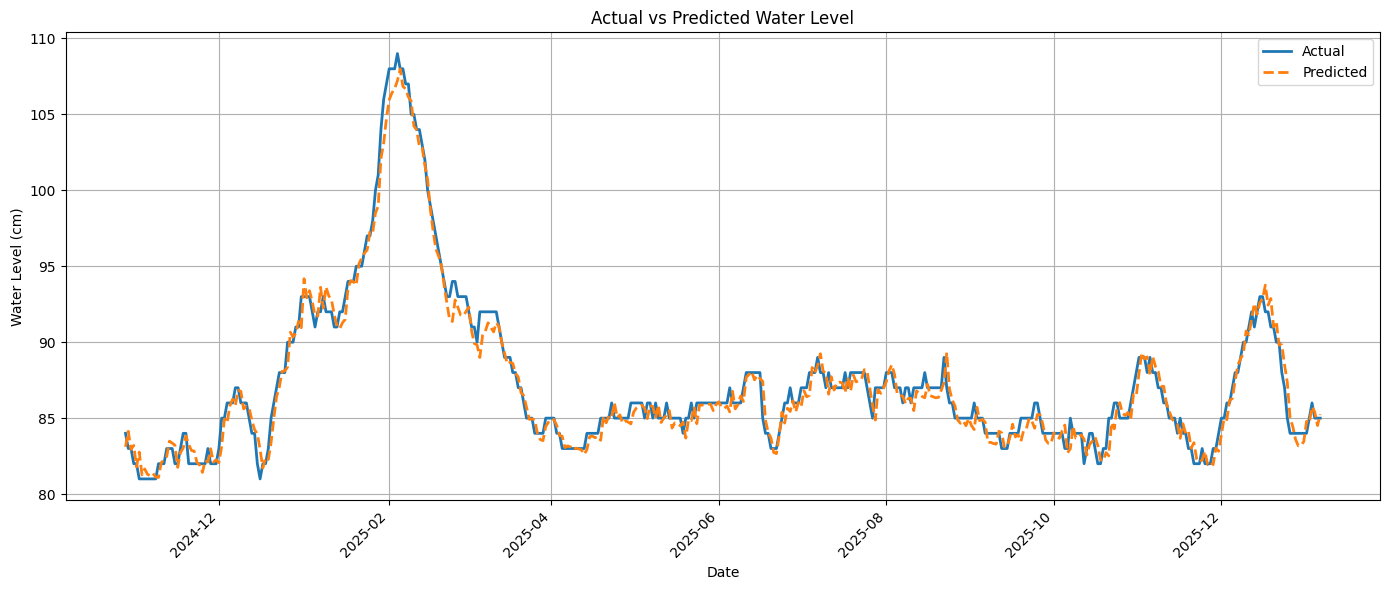

In [63]:
from utils import plot_actual_vs_predicted

plot_path = plot_actual_vs_predicted(
    df=df,
    output_dir=images_dir,
    output_filename=f"actual_vs_predicted_{sensor_name}_{sensor_id}.png",
)

### Store the model in Hopsworks model registry

In [64]:
model_dir = artifacts_dir + "/models"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

model_name = f"model_{sensor_name}_{sensor_id}"
xgb_regressor.save_model(model_dir + f"/{model_name}.json")

In [65]:
res_dict = {
    "MSE": str(mse),
    "R squared": str(r2),
}

In [66]:
mr = project.get_model_registry()

# Creating a Python model in the model registry
wl_model = mr.python.create_model(
    name=model_name,
    metrics=res_dict,
    feature_view=fv,
    description="Water Level predictor",
)

# Saving the model in the model registry
wl_model.save(model_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /home/pshvaiko/Documents/ml_project/notebooks/../artifacts/models/model_malaren_w_20389.json: 0.000%…

Uploading /home/pshvaiko/Documents/ml_project/notebooks/model_schema.json: 0.000%|          | 0/4569 elapsed<0…

Model created, explore it at https://eu-west.cloud.hopsworks.ai:443/p/2184/models/model_malaren_w_20389/3


Model(name: 'model_malaren_w_20389', version: 3)